# CLASE 4.4: INTERPOLACIÓN
---
## Introducción.
En el campo del análisis numérico se denomina **interpolación** a cualquier método que, dado un conjunto discreto de puntos, nos permita determinar puntos intermedios a los existentes. En el caso partícular de los problemas típicos de ciencia e ingeniería, con frecuencia disponemos de un conjunto de datos obtenidos mediante algún proceso físico de muestreo o experimentación. Por ejemplo, muestras de concentrado tomadas cada turno en un circuito de flotación que nos permiten medir, con una precisión instrumental, cantidades importantes para el proceso completo, tales como la ley de concentrado, humedad y granulometría. 

Podemos asumir que tales cantidades representan los valores de una función para un número limitado de valores de un cierto conjunto de variables independientes. Con frecuencia, suele requerirse que interpolemos tales valores, a fin de encontrar cantidades intermedias que permitan mejorar la granularidad de la data de interés. Por ejemplo, si muestreamos leyes de concentrado turno a turno, quizás querramos interpolar dicha data para disponer de valores cada 4 horas (suponiendo que los turnos duran 12 horas). Cualquiera sea el caso, la interpolación suele implicar la resolución del problema complementario: Determinar una función que pase por los puntos muestreados y que tenga una geometría *aproximadamente similar* a la función que genera tales puntos, que en general será desconocida. Tales condiciones geométricas implican restricciones que normalmente se aplican no sólo a los valores de la función a interpolar, sino que también a sus derivadas.

Antes de entrar en detalles relativos a la implementación de una interpolación en Python, primero abordaremos el contexto matemático que nos permite formular este problema de manera consistente. En esta sección, consideraremos primeramente los problemas de tipo unidimensional, y que pueden formularse como sigue: Dado un conjunto con $m$ observaciones del tipo $\left\{ \left( x_{i},y_{i}\right)  \right\}^{m}_{i=1}$, estamos interesados en encontrar una función $f$ tal que $y_{i}=f(x_{i})$, para $1\leq i\leq m$. La función $f$ suele denominarse como **interpolador**, y no es única. De hecho, se desprende, de la descripción del problema, que existen infinitos interpoladores para un conjunto discreto de datos. En general, solemos escribir la función interpoladora $f$ como una combinación lineal de $n$ funciones base, denotadas como $\phi_{j}$, tales que $f\left( x\right)  =\sum\nolimits^{n}_{j=1} c_{j}\phi_{j} \left( x\right)$, donde los $c_{j}$ son números reales que deseamos determinar, llamados **coeficientes de la interpolación**.

Al sustituir los puntos $\left\{ \left( x_{i},y_{i}\right)  \right\}^{m}_{i=1}$ en la combinación lineal anterior, el resultado es un sistema lineal de $m$ ecuaciones con $n$ incógnitas. Por supuesto, idealmente nos interesamos en el caso $m=n$, a fin de asegurar una solución única para dicho sistema. Tal sistema puede escribirse matricialmente como

$$\underbrace{\left( \begin{array}{cccc}\phi_{1} \left( x_{1}\right)  &\phi_{2} \left( x_{1}\right)  &\cdots &\phi_{n} \left( x_{1}\right)  \\ \phi_{1} \left( x_{2}\right)  &\phi_{2} \left( x_{2}\right)  &\cdots &\phi_{n} \left( x_{2}\right)  \\ \vdots &\vdots &\ddots &\vdots \\ \phi_{1} \left( x_{n}\right)  &\phi_{2} \left( x_{n}\right)  &\cdots &\phi_{n} \left( x_{n}\right)  \end{array} \right)  }_{\mathbf{\Phi(\mathbf{x}) } } \underbrace{\left( \begin{array}{c}c_{1}\\ c_{2}\\ \vdots \\ c_{n}\end{array} \right)  }_{\mathbf{c} } =\underbrace{\left( \begin{array}{c}y_{1}\\ y_{2}\\ \vdots \\ y_{n}\end{array} \right)  }_{\mathbf{y} }$$
</p> <p style="text-align: right;">$(4.1)$</p>

Vemos pues que el sistema anterior puede escribirse en forma compacta como $\mathbf{\Phi } \left( \mathbf{x} \right)  \mathbf{c} =\mathbf{y}$. En esta formulación, con $m=n$, se tiene que el número de funciones base es el mismo que el número de puntos observados para construir la interpolación y, por extensión, $\mathbf{\Phi } \left( \mathbf{x} \right)$ es una matriz cuadrada de orden $n$.

La elección de las funciones base afecta, por supuesto, a las propiedades del sistema (4.1), y una elección adecuada dependerá de las propiedades de la data que queremos interpolar. Algunos tipos frecuentes de funciones base incluyen funciones potenciales del tipo $\phi_{j}(x)=x^{j-1}$, polinomios ortogonales, o polinomios definidos entre cada par de puntos (llamados **splines**). Notemos que, si bien no existe una única función interpoladora, sí existe un único polinomio de interpolación y que es independiente de las funciones base escogidas. Esto lo veremos en detalle un poco más adelante.

En esta sección, haremos uso de **Scipy** para construir interpolaciones de forma eficiente. En particular, haremos uso del módulo `scipy.interpolate`, el cual se especializa en este tipo de problemas. Nos apoyaremos igualmente con el módulo de álgebra lineal de **Scipy**, llamado `scipy.linalg`, y el módulo especializado en polinomios de **Numpy**, llamado `numpy.polynomial`:

In [1]:
# Importación de librerías.
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sympy

In [2]:
# Importación de módulos.
from numpy import polynomial as P
from scipy import interpolate
from scipy import linalg

In [3]:
# Setting de parámetros de graficación.
sns.set()
plt.rcParams["figure.dpi"] = 100 # Resolución de nuestras figuras.
plt.style.use("seaborn-v0_8-white") # Template de estilo.

In [4]:
# Inicializamos la impresión resultados simbólicos de Sympy.
sympy.init_printing()

In [5]:
%matplotlib notebook

## Interpolación polinomial.
La **interpolación polinomial** es el caso particular cuando las funciones base del sistema (4.1) se construyen a partir de la base canónica del conjunto de todos los polinomios de orden $n-1$ (que solemnos denominar como $\mathbb{R}_{n-1}[x]$), y que se escribe como $\alpha=\left\{ 1,x,...,x^{n-1}\right\}$. Luego, estamos interesados en determinar el polinomio $P_{n-1}\in \mathbb{R}_{n-1}[x]$ que interpola a una función arbitraria $f$ en los puntos $(x_{i},y_{i})_{i=1}^{n}$. De esta manera, $P_{n-1}(x_{i})=y_{i}$ para $i=1,...,n$, con lo cual el sistema (4.1) toma la forma

$$\left( \begin{array}{ccccc}1&x_{1}&x^{2}_{1}&\cdots &x^{n-1}_{1}\\ 1&x_{2}&x^{2}_{2}&\cdots &x^{n-1}_{2}\\ 1&x_{3}&x^{2}_{3}&\cdots &x^{n-1}_{3}\\ \vdots &\vdots &\vdots &\ddots &\vdots \\ 1&x_{n}&x^{2}_{n}&\cdots &x^{n-1}_{n}\end{array} \right)  \left( \begin{array}{c}c_{1}\\ c_{2}\\ c_{3}\\ \vdots \\ c_{n}\end{array} \right)  =\left( \begin{array}{c}y_{1}\\ y_{2}\\ y_{3}\\ \vdots \\ y_{n}\end{array} \right)$$
</p> <p style="text-align: right;">$(4.2)$</p>

Este sistema puede escribirse de manera compacta como $\mathbf{V} \mathbf{c} =\mathbf{y}$, donde $\mathbf{V}$ es una matriz de Vandermonde; es decir, una matriz tal que cada una de sus filas constituyen una progresión geométrica. Es posible demostrar que una matriz de Vandermonde es no singular (es decir, invertible y con determinante no nulo, $\det \left( \mathbf{V} \right)  =\prod\nolimits^{n}_{j=1;i>j} \left( x_{i}-x_{j}\right)$) siempre que las progresiones geométricas en cada fila estén definidas en función de variables diferentes, que es el caso para la matriz $\mathbf{V}$. Por lo tanto, el sistema (4.2) tiene solución única y, por extensión, existe un único polinomio de grado $n-1$ que interpola a la función $f$ en los puntos $(x_{i},y_{i})_{i=1}^{n}$.

**Ejemplo 4.1:** En la siguiente tabla se especifican los valores que toma una función $f$ desconocida en un conjunto dado de valores de $x$:

| Valor de $x_{i}$ | Valor de $y_{i}$ |
| :--------------: | :--------------: |
| -1               | -1               |
| 2                | -4               |
| 4                | 4                |

Vamos a utilizar la igualdad (4.2) para encontrar el polinomio $P$ de menor grado que interpola estos puntos. Es evidente que $P$ es un polinomio de grado 4, ya que tenemos 5 puntos en total para ejecutar la interpolación. De esta manera, podemos escribir $P$ como $P\left( x\right)  =\sum\nolimits^{2}_{i=0} c_{i}x^{i}$, siendo tal que $P(-1)=-1, P(2)=-4$ y $P(4)=4$. De esta manera, llegamos al sistema

$$\left( \begin{array}{rrr}1&-1&1\\ 1&2&4\\ 1&4&16\end{array} \right)  \left( \begin{array}{r}c_{0}\\ c_{1}\\ c_{2}\end{array} \right)  =\left( \begin{array}{r}-1\\ -4\\ 4\end{array} \right)$$
</p> <p style="text-align: right;">$(4.3)$</p>

Este sistema puede resolverse fácilmente haciendo uso de **Sympy**:

In [6]:
# Definimos las incógnitas del sistema.
c0, c1, c2 = sympy.symbols("c_{0}, c_{1}, c_{2}", real=True)
c = sympy.Matrix([c0, c1, c2])

In [7]:
# Definimos la matriz de Vandermonde con los coeficientes del sistema.
V = sympy.Matrix([
    [1, -1, 1],
    [1, 2, 4],
    [1, 4, 16],
])

In [8]:
# Definimos la matriz resultante del sistema.
y = sympy.Matrix([-1, -4, 4])

In [9]:
# Resolvemos el sistema mediante una factorización LU.
result = V.LUsolve(y)

In [10]:
# Mostramos el resultado en pantalla.
result.T

[-4  -2  1]

Por lo tanto, el polinomio interpolador está dado por $P(x)=-4-2x+x^{2}$. ◼

En general, no es recomendable determinar polinomios de interpolación mediante el uso del método basado en las matrices de Vandermonde. La razón de aquello estriba en que los sistemas matriciales del tipo (4.2) suelen estar mal condicionados, lo que implica que pequeñas variaciones en los elementos de la matriz $\mathbf{V}$ pueden producir enormes diferencias en las soluciones resultantes del sistema $\mathbf{V} \mathbf{c} =\mathbf{y}$, siendo así propensas a grandes errores de redondeo. Por esta razón es que existen otros enfoques que permiten obtener de manera mucho más efectiva los polinomios de interpolación (por ejemplo, los métodos de Lagrange y de interpolación por diferencias divididas).

### Creación de polinomios en Python.
La librería **Numpy** nos provee del módulo `numpy.polynomial` (que suele importarse mediante el alias `P`), y que nos permite utilizar una serie de funciones y clases especializadas en el trabajo con polinomios. En particular, nos permite trabajar con familias especiales de polinomios denominadas **ortogonales** con respecto a una función de peso. Formalmente, dos polinomios $P_{m}(x)$ y $P_{n}(x)$ son ortogonales con respecto a una función de peso $w:\left[ a,b\right]  \rightarrow \mathbb{R}$ si se cumple que

$$\left< P_{m}\left( x\right)  ,P_{n}\left( x\right)  \right>  =\int^{b}_{a} P_{m}\left( x\right)  P_{n}\left( x\right)  w\left( x\right)  dx=0$$
</p> <p style="text-align: right;">$(4.4)$</p>

Los polinomios ortogonales son importantes en el análisis numérico y la interpolación. Por lo tanto, previo a entrar de lleno a la implementación de interpolaciones polinomiales por medio de **Scipy**, haremos un pequeño tour por el módulo `numpy.polynomial`. Dicho módulo cuenta con funciones y clases para representar polinomios en diferentes bases. La base canónica de $\mathbb{R}_{n}[x]$, como comentamos previamente, es $\alpha=\left\{ 1,x,x^{2},...,x^{n}\right\}$, y es posible construir polinomios sobre dicha base en `numpy.polynomials` usando la clase `Polynomial`. Por ejemplo, podemos construir el polinomio $P\left( x\right)  =2-x+5x^{2}-4x^{3}$ imputando los coeficientes en el orden de la base canónica, en el formato de una lista de Python, como sigue:

In [11]:
# Construimos nuestro polinomio (sobre la base canónica).
P1 = P.Polynomial([2, -1, 5, -4])

Si tenemos activa la impresión de variables simbólicas de **Sympy**, al mostrar este polinomio en pantalla, veremos su expresión simbólica completa:

In [12]:
# Mostramos nuestro polinomio en pantalla.
P1

Polynomial([ 2., -1.,  5., -4.], domain=[-1,  1], window=[-1,  1])

Pero si no tenemos activa dicha opción, lo que veremos será lo siguiente:

In [13]:
# Polynomial([ 2., -1., 5., -4.], domain=[-1, 1], window=[-1, 1])

Alternativamente, también es posible crear un polinomio a partir de sus raíces. Es decir, a partir de los puntos $x_{i}$ tales que $P_{n-1}(x_{i})=0$ (donde $0\leq i\leq n-1$). Para ello, podemos usar el método `fromroots()` a partir de la clase `Polynomial`, la cual creará un polinomio $P_{n-1}(x)$ con raíces $x_{i}$ a partir de la expresión $P_{n-1}(x)=\left( x-x_{0}\right)  \left( x-x_{1}\right)  \cdots \left( x-x_{n-1}\right)  =\prod\nolimits^{n-1}_{i=0} \left( x-x_{i}\right)$. Por ejemplo:

In [14]:
# Creamos un polinomio a partir de las raíces x=-1 y x=1.
P2 = P.Polynomial.fromroots([-1, 1])

In [15]:
# Mostramos nuestro polinomio en pantalla.
P2

Polynomial([-1.,  0.,  1.], domain=[-1.,  1.], window=[-1.,  1.])

Vemos pues que el polinomio creado es $P\left( x\right)  =\left( x-1\right)  \left( x+1\right)  =x^{2}-1$.

Por otro lado, para cualquier polinomio creado en `numpy.polynomial`, podemos calcular las correspondientes raíces, usando el método `roots()`, sobre la instancia de la clase `Polynomial`:

In [16]:
# Calculamos las raíces del polinomio P1.
P1.roots()

array([-0.04574119-0.60879368j, -0.04574119+0.60879368j,
        1.34148238+0.j        ])

In [17]:
# Calculamos las raíces del polinomio P2.
P2.roots()

array([-1.,  1.])

Cada instancia de la clase `Polynomial` contiene tres listas que lo caracterizan. La primera contiene los coeficientes del polinomio respectivo, y que solemos imputar a su constructor. Las otras dos listas son `domain` y `window`, y que representan el dominio y recorrido del polinomio en términos de la correspondiente transformación lineal entre `domain[i]` y `window[i]`, a modo de factores de escalamiento y traslación (es decir, del tipo $T(v)=\lambda v$, con $\lambda \in \mathbb{R}$). Los valores por defecto son `domain=[-1, 1]` y `window=[-1, 1]`, los que implican que no se aplica ningún factor de escalamiento. Estos atributos resultan particularmente útiles cuando trabajamos con polinomios ortogonales con respecto a alguna función de peso sobre un intervalo específico (como en la Ec. (4.4)). Podemos acceder a todas estas propiedades mediante los atributos `coef`, `domain` y `window`, respectivamente:

In [18]:
# Coeficientes del polinomio P1.
P1.coef

array([ 2., -1.,  5., -4.])

In [19]:
# Dominio del polinomio P1.
P1.domain

array([-1,  1])

In [20]:
# Ventana o recorrido del polinomio P1.
P1.window

array([-1,  1])

Cualquier polinomio creado como una instancia de la clase `Polynomial` puede ser fácilmente evaluado sobre valores arbitrarios de $x$, usando dicha instancia como una función cuyo argumento será un arreglo unidimensional con los valores de $x$ que sean de interés. Por ejemplo, si queremos evaluar el polinomio `P1` en un intervalo de valores comprendido en el rango $[-1, 1]$, bastará con escribir:

In [21]:
# Evaluación de P1 en el rango [-1, 1].
x = np.linspace(start=-1, stop=1, num=100)
y = P1(x)

<IPython.core.display.Javascript object>


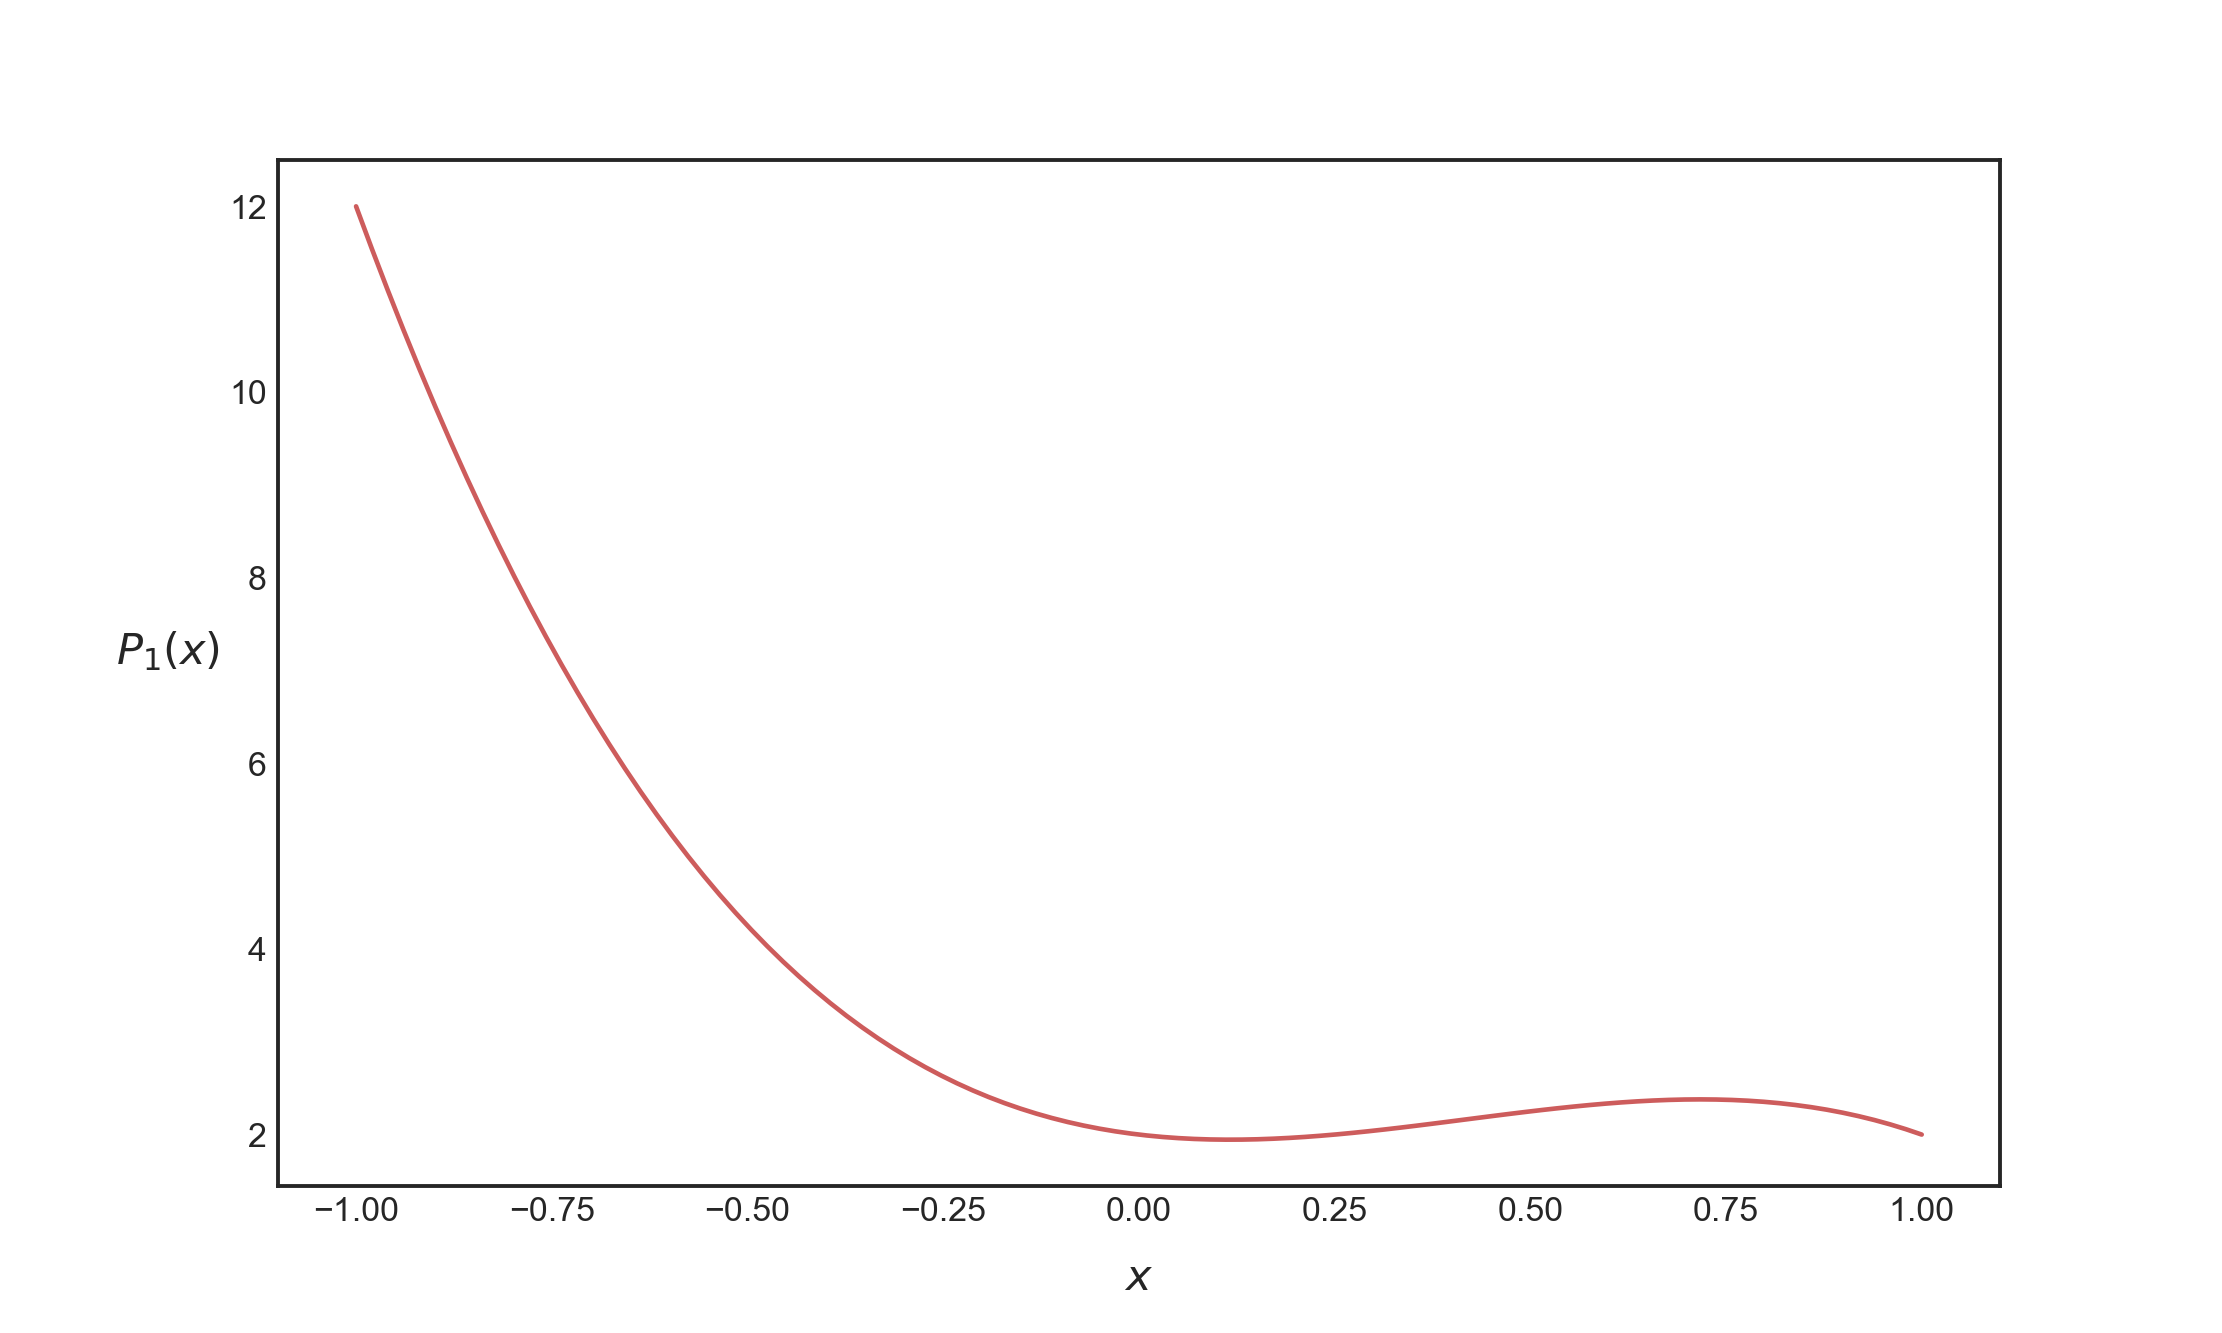

In [22]:
# Graficamos nuestro polinomio.
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, y, color="indianred")
ax.set_xlabel(r"$x$", fontsize=14, labelpad=10)
ax.set_ylabel(r"$P_{1}(x)$", fontsize=14, labelpad=20, rotation=0);

Las instancias de la clasde `Polynomial` puede, además, ser operadas aritméticamente de manera clásica, de la misma forma en que lo haríamos con arreglos de **Numpy**. La única diferencia es que el operador `//`, que es usado para la división entera entre elementos de un arreglo, al aplicarla sobre polinomios, se convertirá literalmente en una división algebraica de polinomios. Para comprobar esto, calcularemos la división entre los polinomios $P(x)$ y $Q(x)$, definidos como $Q(x)=(x-4)(x+5)(x-2)$ y $R(x)=x+5$. Al expresar los polinomios de esta manera, es evidente que el resultado de la división entre $Q$ y $R$ será $Q(x)/R(x)=(x-4)(x-2)=x^{2}-6x+8$. Comprobémoslo:

In [23]:
# Construimos los polinomios Q y R.
Q = P.Polynomial.fromroots([-5, 2, 4])
R = P.Polynomial.fromroots([-5])

In [24]:
# Realizamos la división entre Q y R.
Q // R

Polynomial([ 8., -6.,  1.], domain=[-1.,  1.], window=[-1.,  1.])

Lo que, efectivamente, comprueba nuestro cálculo.

La clase `Polynomial` también nos permite crear polinomios en otras bases no canónicas, pero que son igualmente ortogonales. Ejemplos de estas bases corresponden a la familia de polinomios ortogonales de Chebyshev, que pueden construirse a partir de la solución de la ecuación diferencial

$$\left( 1-x^{2}\right)  \frac{d^{2}y}{dx^{2}} -x\frac{dy}{dx} +n^{2}y=0$$
</p> <p style="text-align: right;">$(4.5)$</p>

Y que pueden definirse mediante la siguiente relación de recurrencia

$$T_{0}\left( x\right)  =1\  ;\  T_{1}\left( x\right)  =x\  ;\  T_{n+1}\left( x\right)  =2xT_{n}\left( x\right)  -T_{n-1}\left( x\right)$$
</p> <p style="text-align: right;">$(4.6)$</p>

Estos polinomios son ortogonales con respecto a la función de peso $w\left( x\right)  =\frac{1}{\sqrt{1-x^{2}} }$ en el intervalo $[-1, 1]$.

Cada uno de los polinomios de Chebyshev hasta de grado $n$ conforma las componentes de una base del conjunto $\mathbb{R}_{n}[x]$. Es posible usar esta base para construir polinomios en función de los polinomios de Chebyshev usando la clase `Chebyshev` del módulo `numpy.polynomial`. Por ejemplo, si escribimos `P.Chebyshev([1, 2, 3])`, obtendremos el polinomio $P(x)=1\cdot T_{0}(x)+2\cdot T_{1}(x)+3\cdot T_{2}(x)$:

In [25]:
# Nuestro primer polinomio de Chebyshev.
T = P.Chebyshev([1, 2, 3])

In [26]:
# Mostramos nuestro polinomio en pantalla.
T

Chebyshev([1., 2., 3.], domain=[-1,  1], window=[-1,  1])

Dada la forma en la cual construimos los polinomios anteriores, es posible construir cualquier polinomio de Chebyshev controlando los valores de cada una de las bases. Por ejemplo, si sólo usamos la base asociada a cada polinomio por dimensión, podremos construir $T_{n}(x)$ para cualquier valor de $n$:

In [27]:
# Polinomios de Chebyshev hasta grado 5.
T0 = P.Chebyshev([1])
T1 = P.Chebyshev([0, 1])
T2 = P.Chebyshev([0, 0, 1])
T3 = P.Chebyshev([0, 0, 0, 1])
T4 = P.Chebyshev([0, 0, 0, 0, 1])
T5 = P.Chebyshev([0, 0, 0, 0, 0, 1])

<IPython.core.display.Javascript object>


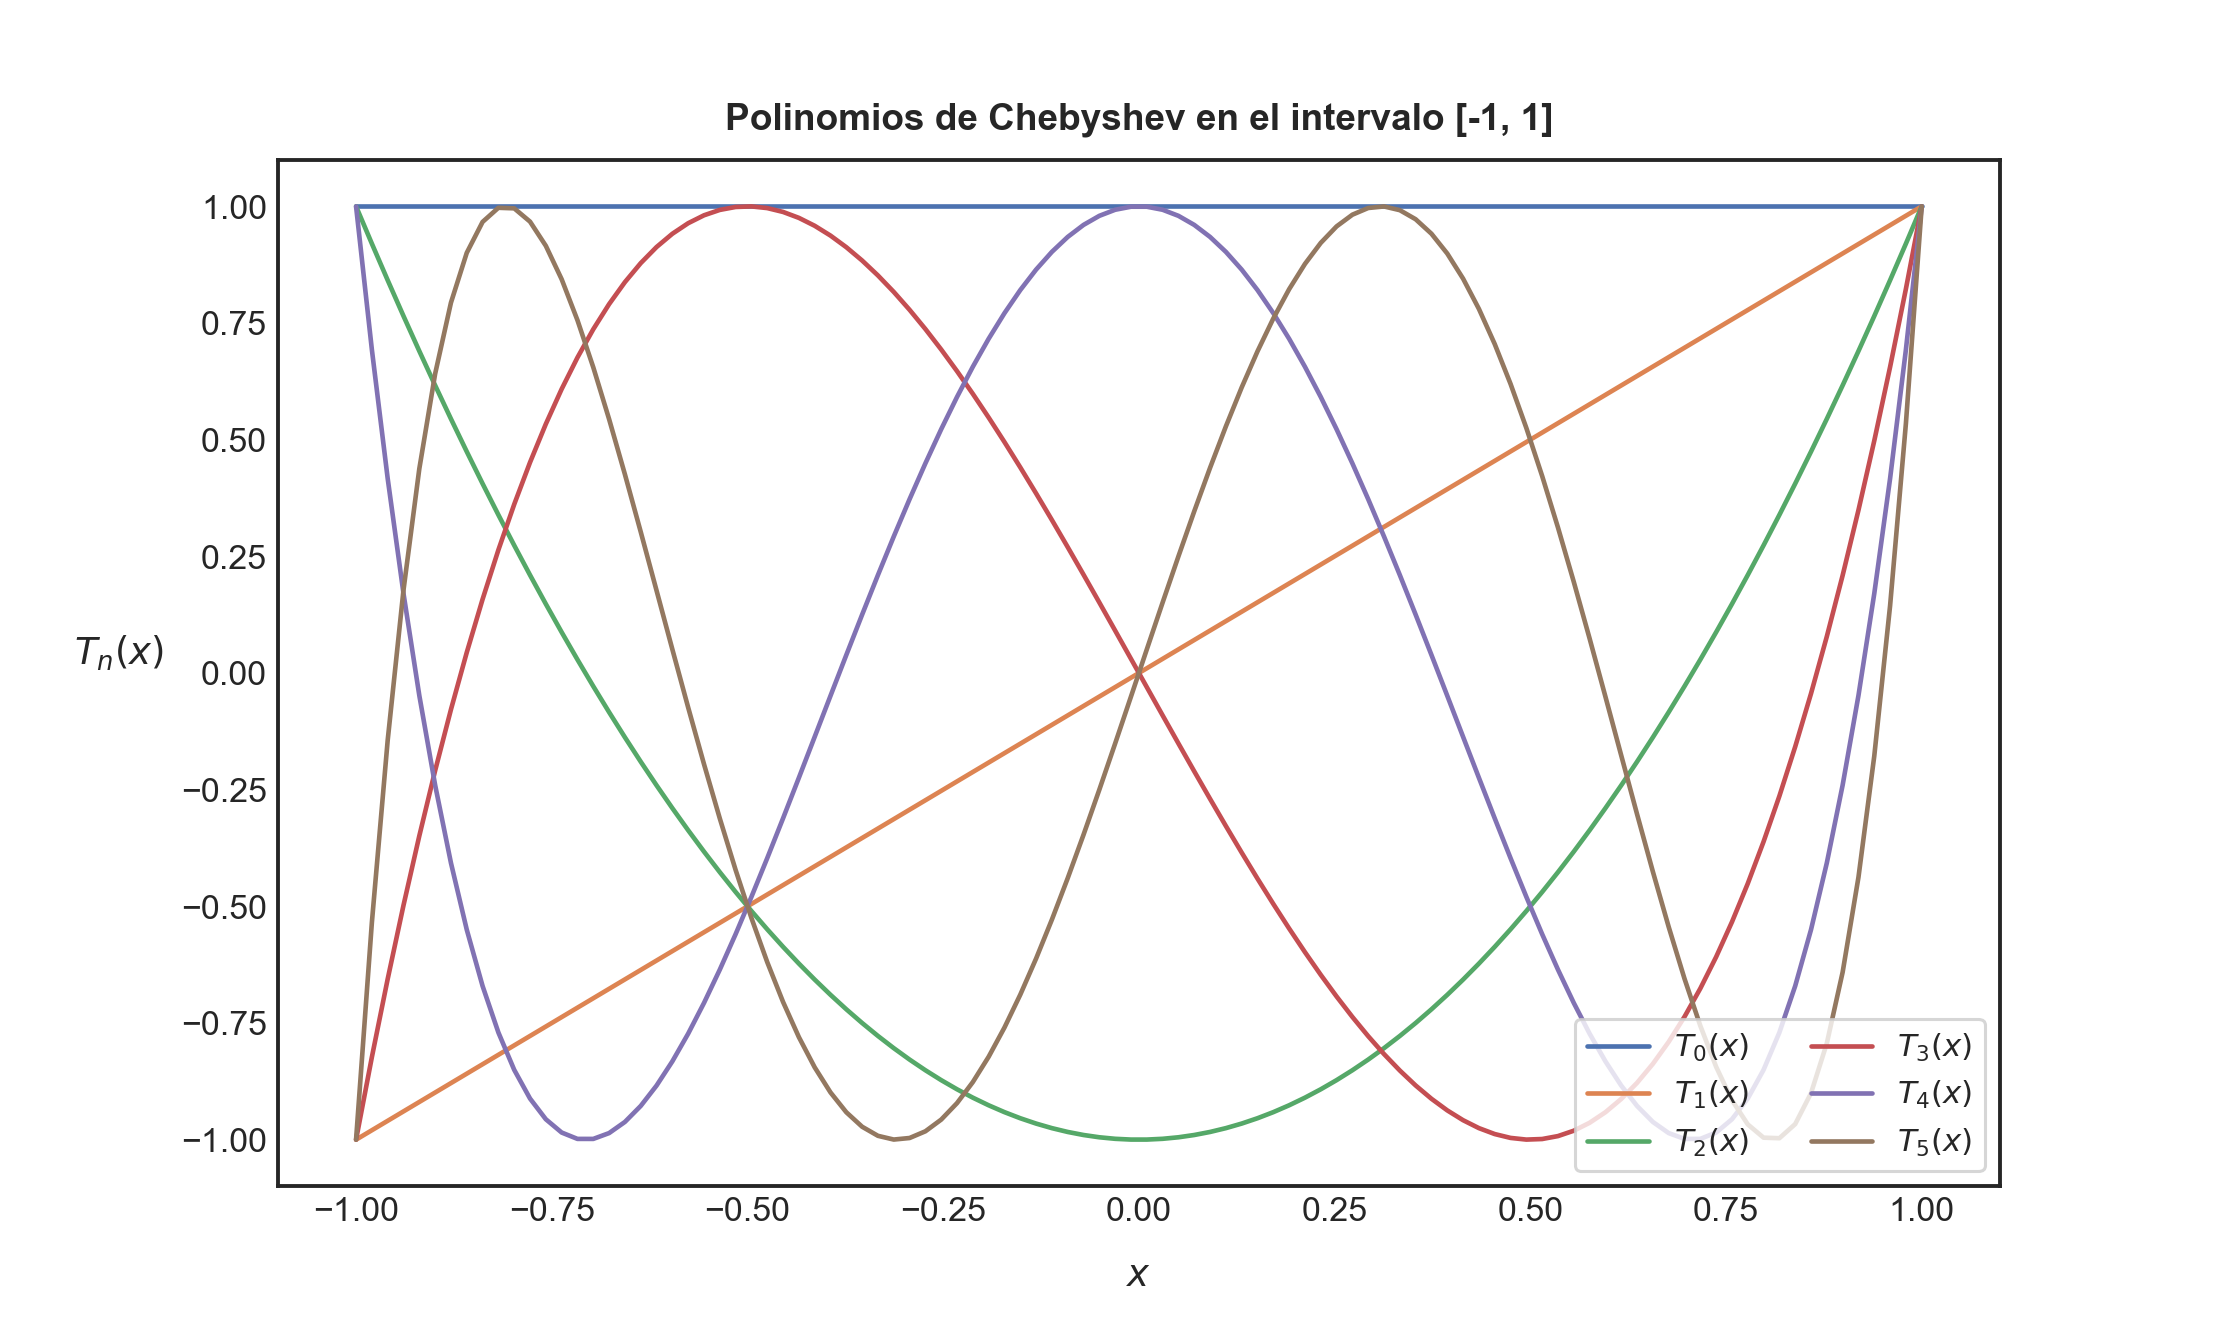

In [28]:
# Graficamos los polinomios de Chebyshev.
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, T0(x), label=r"$T_{0}(x)$")
ax.plot(x, T1(x), label=r"$T_{1}(x)$")
ax.plot(x, T2(x), label=r"$T_{2}(x)$")
ax.plot(x, T3(x), label=r"$T_{3}(x)$")
ax.plot(x, T4(x), label=r"$T_{4}(x)$")
ax.plot(x, T5(x), label=r"$T_{5}(x)$")
ax.set_xlabel(r"$x$", fontsize=12, labelpad=10)
ax.set_ylabel(r"$T_{n}(x)$", fontsize=12, labelpad=20, rotation=0)
ax.set_title(r"Polinomios de Chebyshev en el intervalo [-1, 1]", fontsize=12, fontweight="bold", pad=10)
ax.legend(loc="lower right", fontsize=10, frameon=True, ncol=2);

El módulo `numpy.polynomials` puede construir polinomios en base a cualquier base ortogonal. Existen varias opciones clásicas además de la definida a partir de los polinomios de Chebyshev. Por ejemplo, contamos con un constructor base para polinomios de Legendre (`Legendre`), Laguerre (`Laguerre`), Hermite (`Hermite` y `HermiteE`, para polinomios físicos y probabilísticos de Hermite, respectivamente). De esta manera, si escribimos `P.Laguerre([-1, 1, 2, 4])`, obtendremos un polinomio a partir de la expresión generadora $P(x)=-L_{0}(x)+L_{1}(x)+2L_{2}(x)+4L_{3}(x)$, donde $L_{n}(x)$ es el polinomio de Laguerre de grado $n$:

$$L_{n}\left( x\right)  =\frac{\exp \left( x\right)  }{n!} \frac{d^{n}}{dx^{n}} \left( x^{n}\exp \left( -x\right)  \right)$$
</p> <p style="text-align: right;">$(4.7)$</p>

En efecto:

In [29]:
# Nuestro primer polinomio de Laguerre.
L = P.Laguerre([-1, 1, 2, 4])

In [30]:
# Mostramos este polinomio.
L

Laguerre([-1.,  1.,  2.,  4.], domain=[0, 1], window=[0, 1])

Todos los constructores de polinomios en `numpy.polynomials` tienen los mismos métodos y atributos. De esta manera, de la misma forma que lo hicimos con instancias de tipo `Polynomial`, podemos usar la instancia `Chebyshev` o `Laguerre` para construir un polinomio a partir de un conjunto de raíces:

In [31]:
# Polinomios en las bases de Chebyshev y Laguerre, con raíces -1, 0, 1.
Pol1 = P.Chebyshev.fromroots([-1, 0, 1])
Pol2 = P.Laguerre.fromroots([-1, 0, 1])

In [32]:
Pol1

Chebyshev([ 0.  , -0.25,  0.  ,  0.25], domain=[-1.,  1.], window=[-1.,  1.])

In [33]:
Pol2

Laguerre([  5., -17.,  18.,  -6.], domain=[0., 1.], window=[0., 1.])

### Interpolación polinomial por medio de `numpy.polynomial`.
Los constructores de polinomios previamente comentados nos proveen de métodos útiles para la implementación de interpolaciones polinomiales. Por ejemplo, si recordamos la ecuación matricial que define a un problema general de interpolación, $\mathbf{\Phi } \left( \mathbf{x} \right)  \mathbf{c} =\mathbf{y}$, donde $\mathbf{x}$ y $\mathbf{y}$ son vectores que contienen los puntos $x_{i}$ e $y_{i}$, y $\mathbf{c}$ es el vector que contiene los coeficientes que deseamos determinar. Para resolver este problema, primero debemos evaluar la matriz $\mathbf{\Phi } \left( \mathbf{x} \right)$ para una base dada, y luego resolver el sistema de ecuaciones resultante. Cada una de las clases constructoras de polinomios del módulo `numpy.polynomial` nos provee convenientemente de una función para calcular la matriz (generalizada) de Vandermonde asociada a este sistema. Por ejemplo, para polinomios generados a partir de la base canónica $\left\{ 1,x,x^{2},...,x^{n}\right\}$, podemos usar la función `P.polynomial.polyvander()`; para polinomios generados a partir de la base ortogonal de Chebyshev, podemos usar la función `P.chebyshev.chebvander()`, y así sucesivamente.

El uso de los métodos anteriores para la construcción de matrices de Vandermonde nos permitirá construir interpolaciones polinomiales fácilmente conforme distintas bases ortogonales. Por ejemplo, consideremos los puntos $P_{0}=(-1, 1), P_{1}=(0, 3), P_{2}=(1, 6)$ y $P_{3}=(2, 4)$. Sobre tales puntos podemos construir un polinomio de interpolación de grado 3. Para ello, primero generamos arreglos de **Numpy** que se corresponderán con las abcisas y ordenadas de cada punto:

In [34]:
# Generamos los puntos o nodos de interpolación.
x = np.array([-1, 0, 1, 2])
y = np.array([1, 3, 6, 4])

Buscamos pues un polinomio de tercer grado, de la forma $P_{3}\left( x\right)  =\sum\nolimits^{3}_{i=0} c_{i}x^{i}$. Para ello, simplemente aplicamos el método de construcción de matrices de Vandermonde para construir el sistema de ecuaciones que nos permitirá determinar los coeficientes $c_{i}$:

In [35]:
# Grado del polinomio de interpolación.
n = x.shape[0] - 1

In [36]:
# Matriz de Vandermonde.
V = P.polynomial.polyvander(x, n)

Luego, usamos el módulo de álgebra lineal de **Scipy** (`scipy.linalg`) para resolver el sistema:

In [37]:
# Calculamos los coeficientes de nuestro polinomio de interpolación.
c = linalg.solve(V, y)

In [38]:
# Mostramos la solución del sistema (los coeficientes del polinomio).
c

array([ 3. ,  3.5,  0.5, -1. ])

Vemos pues que el polinomio de interpolación así determinado es $P_{3}=3+3.5x+0.5x^{2}-x^{3}$. Vamos a usar estos coeficientes para construir el polinomio en **Numpy** y comparar gráficamente su recorrido con los puntos de interpolación:

In [39]:
# Llevamos el polinomio a Numpy.
P3 = P.Polynomial(c)

<IPython.core.display.Javascript object>


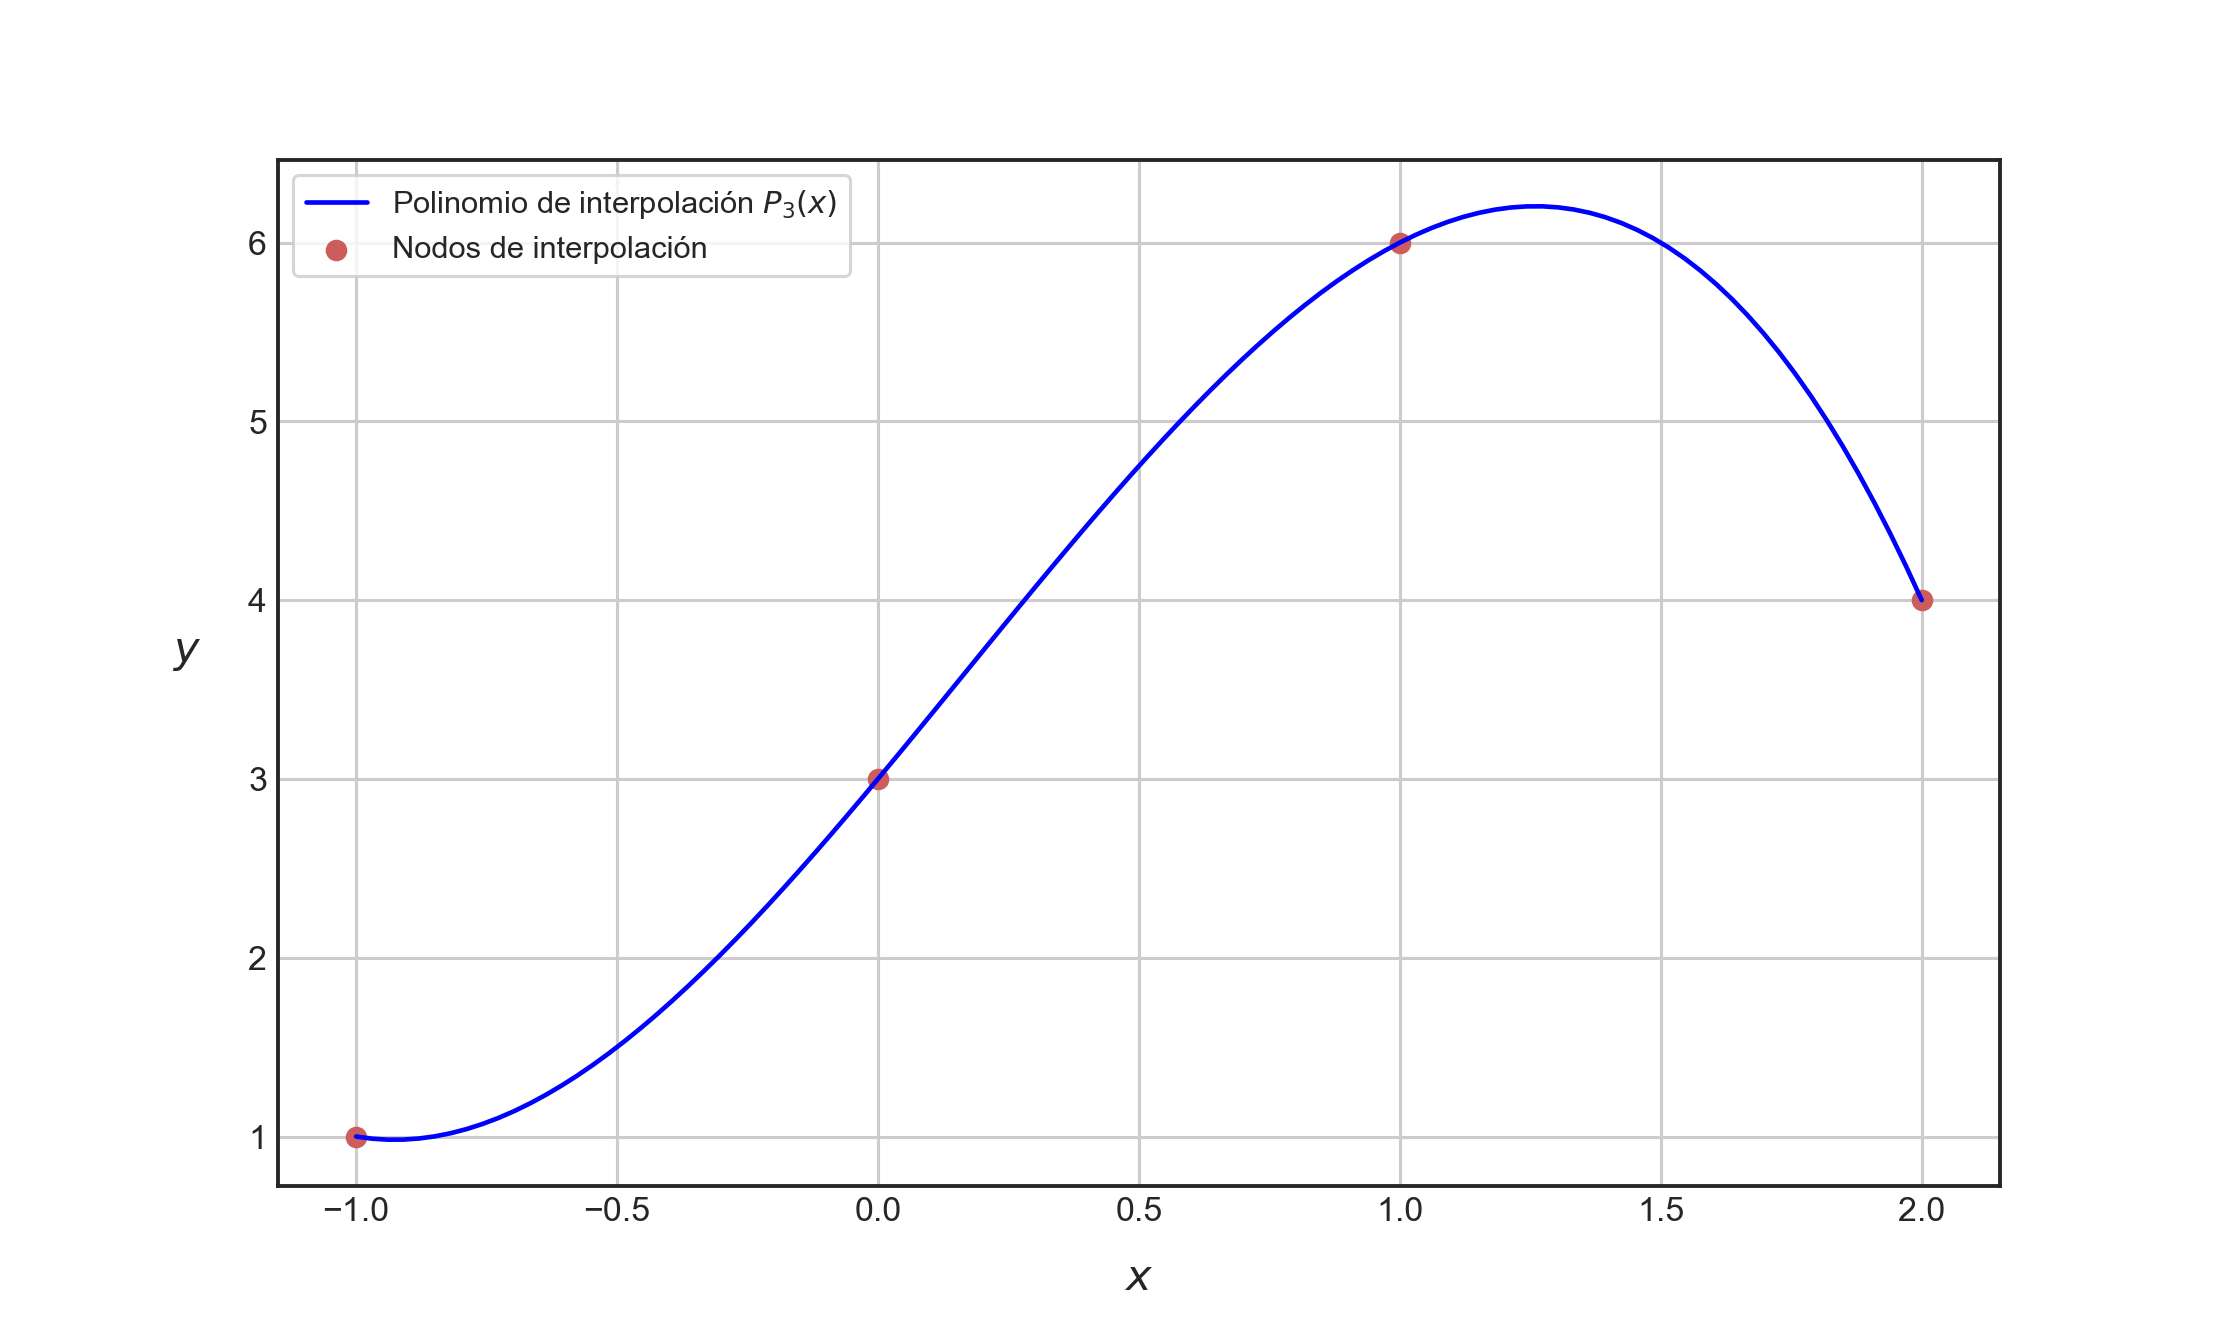

In [40]:
# Graficamos el polinomio y los puntos de interpolación.
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    np.linspace(-1, 2, 100), P3(np.linspace(-1, 2, 100)), 
    color="blue", label=r"Polinomio de interpolación $P_{3}(x)$"
)
ax.scatter(x, y, color="indianred", label="Nodos de interpolación")
ax.set_xlabel(r"$x$", fontsize=14, labelpad=10)
ax.set_ylabel(r"$y$", fontsize=14, labelpad=20, rotation=0)
ax.legend(fontsize=10, loc="upper left", frameon=True)
ax.grid(True);

Podemos observar que nuestro polinomio hace el trabajo que le pedimos de manera perfecta: Interpola sobre los nodos solicitados. Es posible hacer esto para polinomios definidos sobre cualquier base ortogonal. Por ejemplo, si quisiéramos construir un polinomio de interpolación definido sobre la base ortogonal de Chebyshev, digamos $U_{3}(x)$, bastará con:

In [41]:
# Matriz de Vandermonde definida sobre la base de los polinomios de Chebyshev.
A = P.chebyshev.chebvander(x, n)

In [42]:
# Calculamos los coeficientes de nuestro polinomio de interpolación.
d = linalg.solve(A, y)

In [43]:
# Mostramos la solución del sistema (los coeficientes del polinomio).
d

array([ 3.25,  2.75,  0.25, -0.25])

In [44]:
# Llevamos el polinomio a Numpy.
U3 = P.Chebyshev(d)

<IPython.core.display.Javascript object>


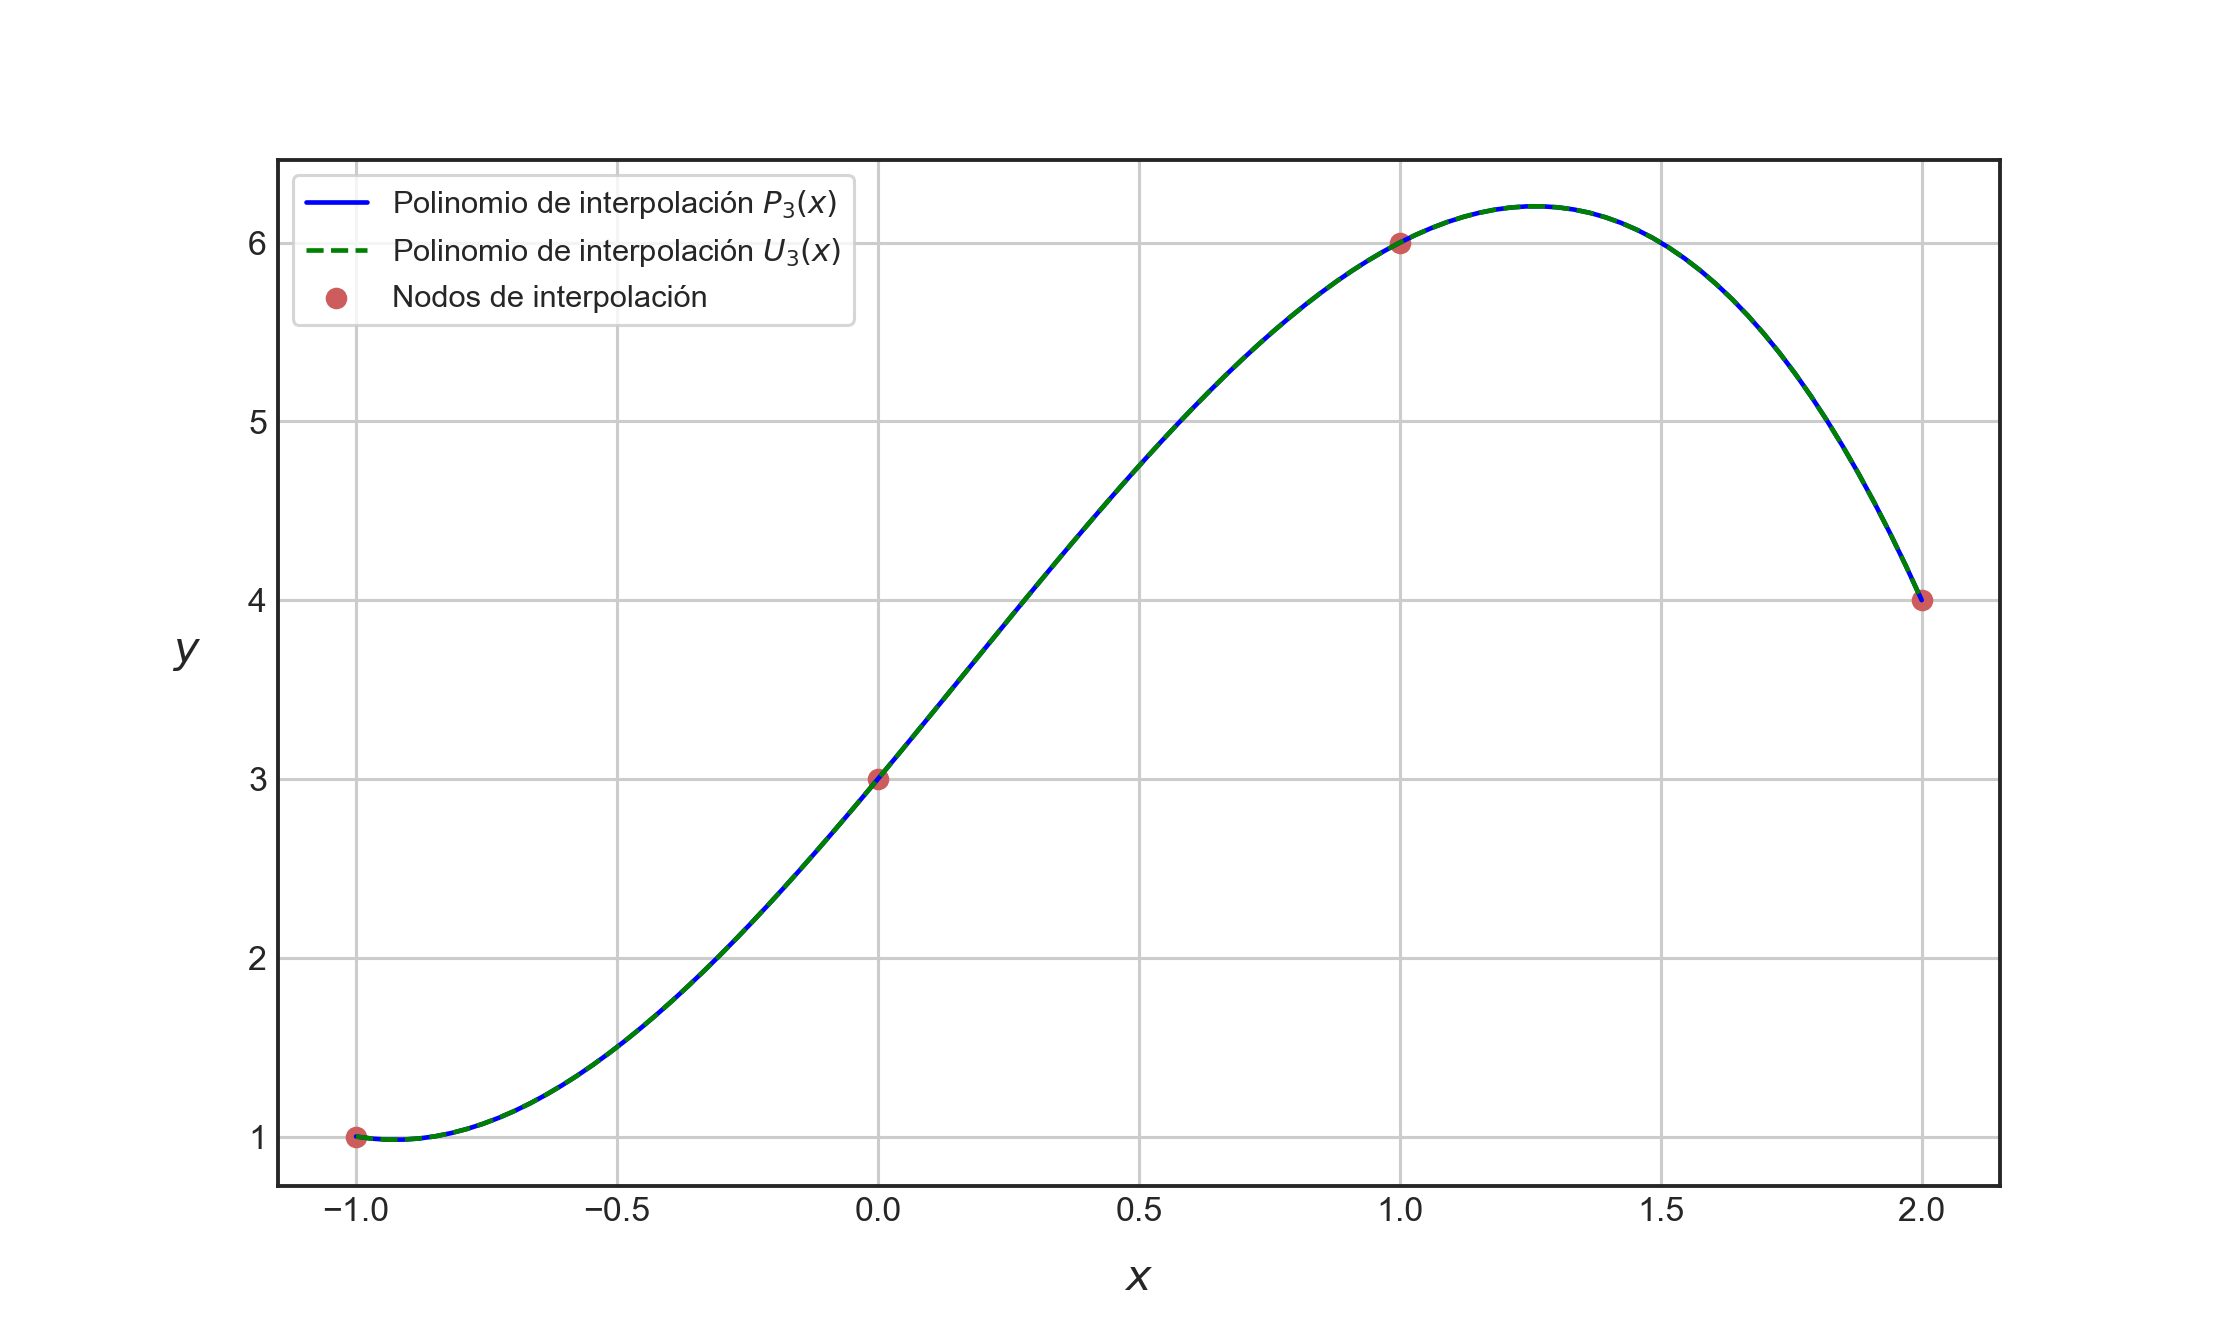

In [45]:
# Graficamos el polinomio y los puntos de interpolación.
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    np.linspace(-1, 2, 100), P3(np.linspace(-1, 2, 100)), 
    color="blue", label=r"Polinomio de interpolación $P_{3}(x)$"
)
ax.plot(
    np.linspace(-1, 2, 100), U3(np.linspace(-1, 2, 100)), 
    color="green", linestyle="--", label=r"Polinomio de interpolación $U_{3}(x)$"
)
ax.scatter(x, y, color="indianred", label="Nodos de interpolación")
ax.set_xlabel(r"$x$", fontsize=14, labelpad=10)
ax.set_ylabel(r"$y$", fontsize=14, labelpad=20, rotation=0)
ax.legend(fontsize=10, loc="upper left", frameon=True)
ax.grid(True);

Notemos que el polinomio de interpolación $U_{3}(x)$ es exactamente igual a $P_{3}(x)$, como lo indica nuestro gráfico anterior. Esto es un resultado esperado, puesto que como comentamos al principio, el polinomio de interpolación es único.

La metodología de interpolación presentada previamente, si bien cumple perfectamente con su función, en general no es muy utilizada en la práctica. La razón de aquello estriba en el hecho de que, para un número elevado de nodos de interpolación, el sistema resultante tiene un número de condición muy elevado, lo que puede inducir a errores indeseables en la determinación de los coeficientes del polinomio de interpolación, independientemente de la base que escojamos. Por esa razón, cada una de las clases que define polinomios en `numpy.polynomial` viene equipada con un método `fit()` que permite construir eficientemente polinomios de interpolación para un número arbitrario de nodos. Y que, naturalmente, nos llevan a los mismos resultados que si aplicáramos el método basado en las matrices de Vandermonde:

In [46]:
# Interpolación directa mediante el método fit() en la base canónica.
P3_fit = P.Polynomial.fit(x, y, n)

In [47]:
# Mostramos el polinomio resultante.
P3_fit

Polynomial([ 4.75 ,  4.875, -2.25 , -3.375], domain=[-1.,  2.], window=[-1.,  1.])

El método de ajuste anterior es aplicable a cualquier base:

In [48]:
# Interpolación directa mediante el método fit() en la base ortogonal de Chebyshev.
U3_fit = P.Chebyshev.fit(x, y, n)

In [49]:
# Interpolación directa mediante el método fit() en la base ortogonal de Hermite.
H3_fit = P.Hermite.fit(x, y, n)

In [50]:
# Mostramos los polinomios resultantes.
print(f"Polinomio interpolador de Chebyshev: {U3_fit}")
print(f"Polinomio interpolador de Hermite: {H3_fit}")

Polinomio interpolador de Chebyshev: 3.6250000000000004 + 2.34375·T₁(x) - 1.1250000000000002·T₂(x) -
0.8437499999999997·T₃(x)
Polinomio interpolador de Hermite: 3.6250000000000004 - 0.09374999999999918·H₁(x) - 0.562500000000001·H₂(x) -
0.4218749999999996·H₃(x)


Notemos que, con este método de ajuste polinomial, el atributo `domain` de las instancias resultantes se setea automáticamente de valores apropiados de $x$, independientemente de las bases utilizadas:

In [51]:
# Dominios de los polinomios interpoladores ajustados.
print(f"Dominio en base canónica: {P3_fit.domain}")
print(f"Dominio en base de Chebyshev: {U3_fit.domain}")
print(f"Dominio en base de Hermite: {H3_fit.domain}")

Dominio en base canónica: [-1.  2.]
Dominio en base de Chebyshev: [-1.  2.]
Dominio en base de Hermite: [-1.  2.]


**Ejemplo 4.2 - El fenómeno de Runge:** La interpolación polinomial resulta ser una herramienta que viene muy bien para generar ajustes sobre conjuntos de puntos no tan numerosos. Cuando el número de puntos aumenta, se hace necesario aumentar el orden de los polinomios de interpolación en la misma proporción. Esto da lugar a ciertos problemas que, en términos gráficos, dan lugar a comportamientos oscilatorios cuando el grado de tales polinomios crece a gran magnitud. Para ejemplificar este efecto, consideremos la *función de Runge*, definida como

$$f\left( x\right)  =\frac{1}{1+25x^{2}}$$
</p> <p style="text-align: right;">$(4.8)$</p>

Esta función fue utilizada por el matemático alemán [Carl Runge](https://en.wikipedia.org/wiki/Carl_Runge) para ilustrar el llamado **fenómeno de Runge**, en el cual, al interpolar la función de Runge en $n$ puntos equidistantes $x_{i}$ en el intervalo $[-1, 1]$, tales que $x_{i}=\frac{2i}{n}-1$ ($i=0, 1, 2, .., n$), mediante un polinomio $P_{n}(x)$ de grado $n$, dicho polinomio presenta un comportamiento notablemente oscilatorio al aproximarse a los extremos de dicho intervalo. Podemos probar algebraicamente que el error de interpolación se incrementa (de manera no acotada) cuando el grado del polinomio de interpolación se incrementa:

$$\lim_{n\rightarrow +\infty } \left( \sup_{-1\leq x\leq 1} \left| f\left( x\right)  -P_{n}\left( x\right)  \right|  \right)  =+\infty$$
</p> <p style="text-align: right;">$(4.9)$</p>

Dicho de otro modo, la interpolación mediante polinomios de alto grado puede resultar problemática. En efecto, si definimos la función de Runge en Python e intentamos generar una interpolación de orden superior a 10, comenzaremos a notar las oscilaciones resultantes de los polinomios en los extremos del intervalo $[-1, 1]$:

In [52]:
# Definimos la función de Runge.
def runge(x):
    return 1 / (1 + 25*x**2)

In [53]:
# Definimos una función que interpolará los nodos resultantes de la evaluación de la función
# de Runge mediante un polinomio de grado n (en la base canonica).
def runge_interpolation(n):
    x = np.linspace(start=-1, stop=1, num=n+1)
    p = P.Polynomial.fit(x, runge(x), n)
    return x, p

<IPython.core.display.Javascript object>


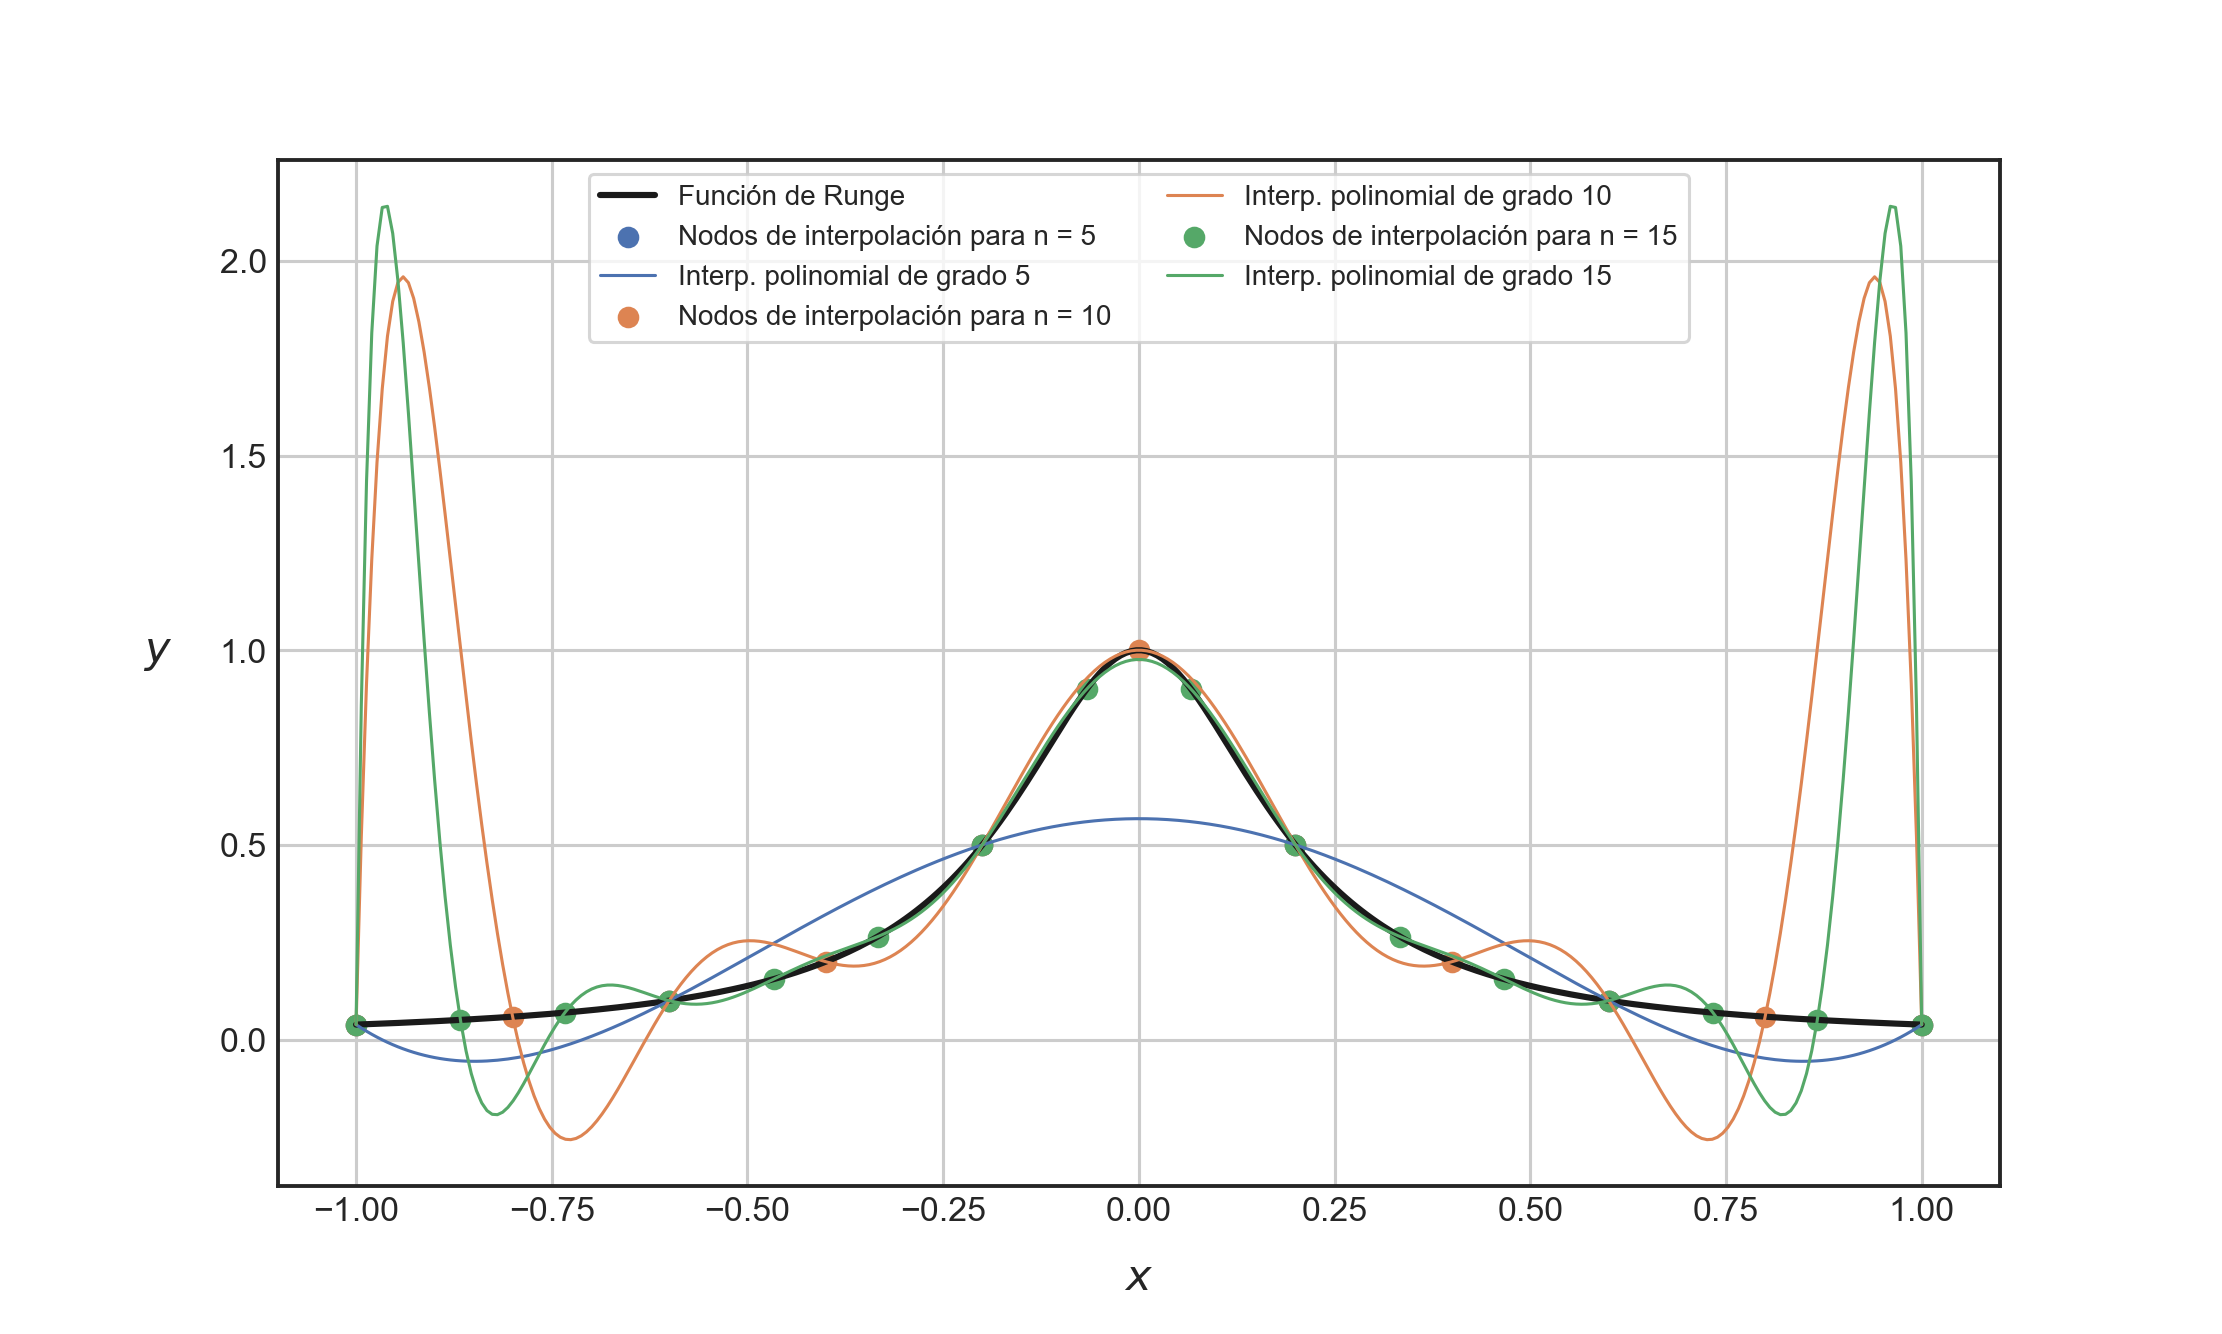

In [54]:
# Graficamos las interpolaciones.
x_range = np.linspace(start=-1, stop=1, num=300)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_range, runge(x_range), color="k", lw=2, label="Función de Runge")

# Verificaremos las interpolaciones de grado 5, 10 y 15.
for n in [5, 10, 15]:
    xi, pi = runge_interpolation(n)
    ax.scatter(xi, runge(xi), marker="o", label=f"Nodos de interpolación para n = {n}")
    ax.plot(x_range, pi(x_range), lw=1, label=f"Interp. polinomial de grado {n}")

ax.set_xlabel(r"$x$", fontsize=14, labelpad=10)
ax.set_ylabel(r"$y$", fontsize=14, labelpad=20, rotation=0)
ax.legend(fontsize=9, loc="upper center", frameon=True, ncol=2)
ax.grid(True);

Este fenómeno ocurre debido, entre otras cosas, a que la magnitud de las derivadas de $f$ también crece a medida que $n$ se hace más grande. ◼

## Interpolación por splines.
Queda claro, dados los resultados del Ejemplo 4.2, que la interpolación polinomial indudablemente presenta límites en su aplicación: A medida que la cantidad de nodos de interpolación crece, la representatividad de los polinomios de interpolación decrece. Por lo tanto, se hacen necesarios otros métodos que no presenten este problema. Y es aquí donde se hace patente la potencia de la **interpolación por splines**, que ya vimos muy brevemente al estudiar el análisis de registros vacíos (o `nan`) en **Pandas**.

### Conceptualización.
Un **spline** se define como una función que se define a trozos, intervalo por intervalo, donde cada uno de estos trozos representa un polinomio de grado determinado. Se trata pues de una función definida a intervalos y que, dada su naturaleza, es preferible en los problemas de interpolación debido a que no presenta los problemas devenidos del fenómeno de Runge, ya que en la mayoría de los casos, los splines de grado 3 serán suficientes para aproximar cualquier función con el error deseado.

Empezaremos nuestra discusión considerando únicamente polinomios de una variable. En este caso, formalmente, un spline se definirá como una función univariable que corresponde a una cierta cantidad de polinomios definidos a intervalos. Esta función, que será llamada $S$, toma valores de un intervalo cerrado $[a, b]$ y los aplica en $\mathbb{R}$; es decir, $S:\left[ a,b\right]  \longrightarrow \mathbb{R}$. Como queremos que $S$ esté definida por intervalos, particionamos $[a, b]$ en sub-intervalos disjuntos del tipo

$$\begin{array}{l}\left[ t_{i},t_{i+1}\right]  ,i=0,1,...,k-1\\ \left[ a,b\right]  =\left[ t_{0},t_{1}\right)  \cup \left[ t_{1},t_{2}\right)  \cup \cdots \cup \left[ t_{k-2},t_{k-1}\right)  \cup \left[ t_{k-1},t_{k}\right)  \cup \left[ t_{k}\right]  \\ a=t_{0}\leq t_{1}\leq \cdots \leq t_{k-1}\leq t_{k}=b\end{array}$$
</p> <p style="text-align: right;">$(4.10)$</p>

Sobre cada una de estas $k$ particiones o "piezas" del intervalo $[a, b]$, queremos definir un polinomio $P_{i}:[t_{i},t_{i+1}]\longrightarrow \mathbb{R}$, el permite definir al spline $S$ completo como

$$\begin{array}{lll}S\left( t\right)  &=&P_{0}\left( t\right)  ,\  t_{0}\leq t<t_{1}\\ S\left( t\right)  &=&P_{1}\left( t\right)  ,\  t_{1}\leq t<t_{2}\\ \vdots &&\\ S\left( t\right)  &=&P_{k-1}\left( t\right)  ,\  t_{k-1}\leq t\leq t_{k}\end{array}$$
</p> <p style="text-align: right;">$(4.11)$</p>

Los $k+1$ puntos dados sobre los cuales se realiza la interpolación son llamados **nodos**. El vector $\mathbf{t}=(t_{0},...,t_{k})$ es llamado **vector nodal** del spline. Si los nodos son equidistantes, diremos que el spline es **uniforme** en $[a, b]$. Si los polinomios que definen los trozos del spline tienen grado al menos $n$, diremos que el spline es, consecuentemente, de grado al menos $n$ (o bien, de orden $n+1$).

Si cada uno de los polinomios que constituyen el spline es de clase, al menos, $C^{r_{i}}$, en la partición $[t_{i-1},t_{i})$, entonces diremos que el spline es **regular** en todo $[a, b]$.

### Implementación en `scipy.interpolate`.
El módulo `scipy.interpolate` nos provee de varias funciones y clases para implementar interpolaciones mediante el uso de splines. Una de ellas corresponde a la función `interp1d()`, la cual toma como argumentos obligatorios los arreglos `x` e `y` que representan los $n+1$ nodos de interpolación $(x_{i},y_{i})_{i=0}^{n}$. Un parámetro opcional es `kind`, y que corresponde al tipo de interpolación que se implementará por medio de esta función. Para una interpolación por medio de splines, bastará con setear `kind` en `"zero"`, `"linear"`, `"quadratic"` o `"cubic"`, dependiendo si queremos construir splines de orden 0, 1, 2 o 3, respectivamente.

Vamos a usar la función de Runge construida previamente para comparar los resultados obtenidos previamente mediante la interpolación polinomial, con los que obtendremos utilizando splines cúbicos. Usaremos como base un total de 12 nodos de interpolación:

In [55]:
# Generamos los nodos de interpolación.
x = np.linspace(start=-1, stop=1, num=12)
y = runge(x)

In [56]:
# Y aplicamos la interpolación por splines cúbicos.
s = interpolate.interp1d(x, y, kind="cubic")

<IPython.core.display.Javascript object>


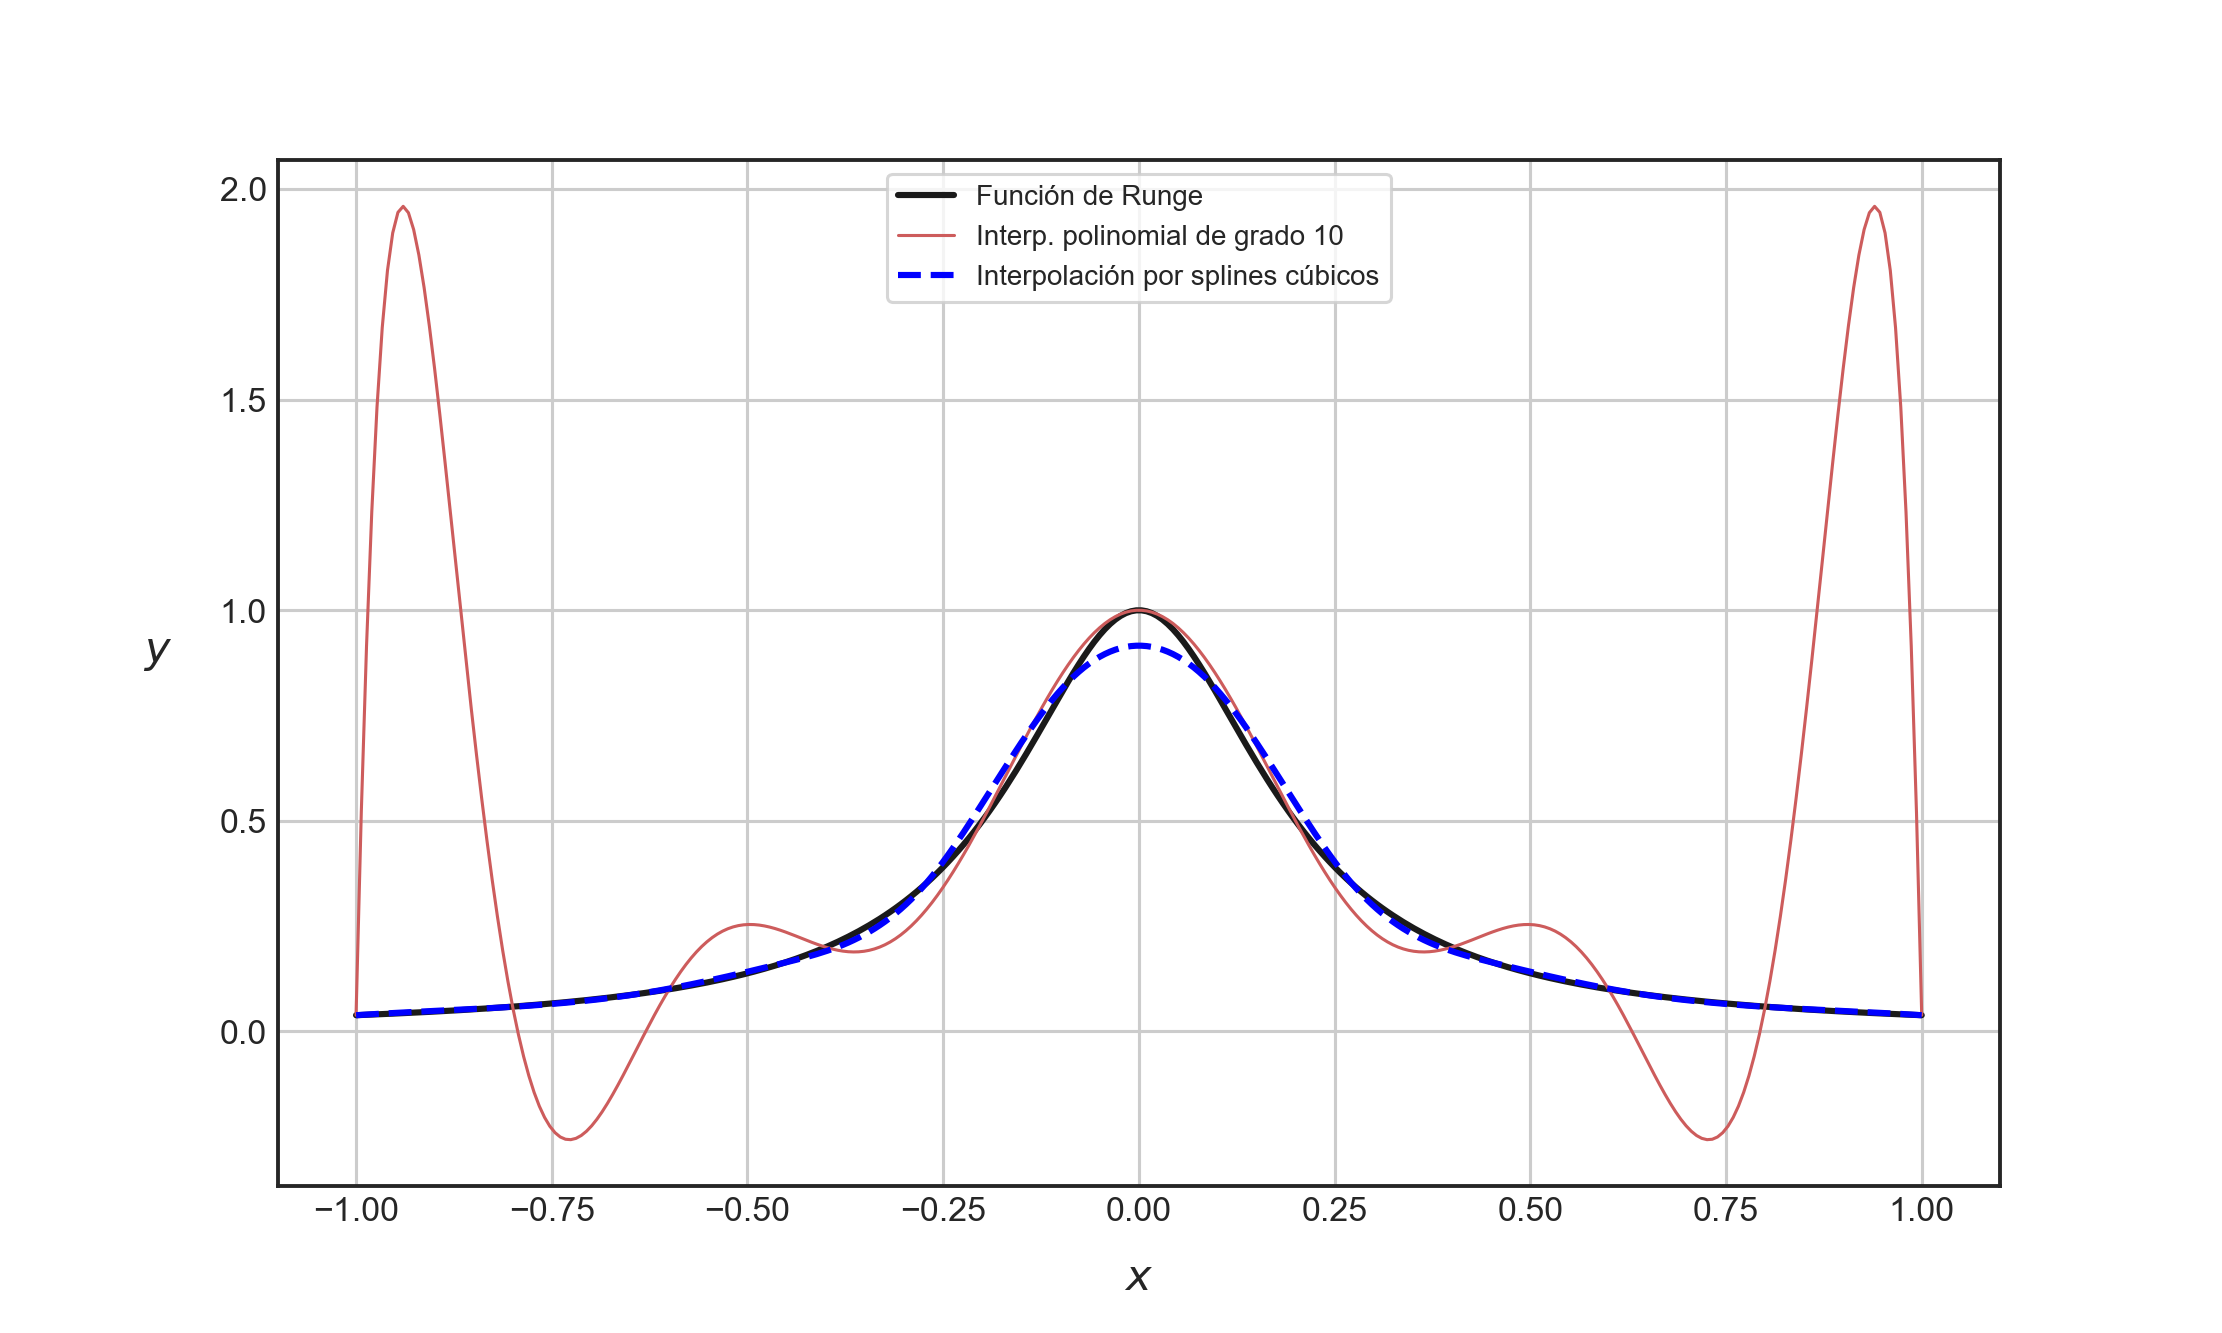

In [57]:
# Y graficamos los resultados.
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_range, runge(x_range), color="k", lw=2, label="Función de Runge")

xp, p = runge_interpolation(n=10) # Interpolación polinomial de orden 10.
ax.plot(x_range, p(x_range), lw=1, color="indianred", label="Interp. polinomial de grado 10")
ax.plot(x_range, s(x_range), lw=2, linestyle="--", color="blue", label="Interpolación por splines cúbicos")

ax.set_xlabel(r"$x$", fontsize=14, labelpad=10)
ax.set_ylabel(r"$y$", fontsize=14, labelpad=20, rotation=0)
ax.legend(fontsize=9, loc="upper center", frameon=True)
ax.grid(True);

Si bien nuestro spline no es perfecto, sí hace un muy buen trabajo aproximando la función de Runge, y sin sufrir de los problemas de oscilación que ocurren en el caso de la interpolación polinomial de alto grado. Además, es una implementación sumamente eficiente, mucho más rápida que la interpolación por medio de matrices de Vandermonde que construimos previamente:

In [58]:
%timeit runge_interpolation(n=10)
%timeit interpolate.interp1d(x, y, kind="cubic")

430 µs ± 46.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
186 µs ± 2.8 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Para ilustrar el efecto del grado asociado al spline interpolador, generaremos un gráfico donde apreciaremos, para el mismo conjunto de puntos, las geometrías asociadas a splines lineales, cuadráticos y cúbicos. Los puntos, en este caso, serán las salidas de la función sinusoidal

$$f(x)=A\cos(\omega x+\phi)$$
</p> <p style="text-align: right;">$(4.12)$</p>

Donde $A, \omega$ y $\phi$ son parámetros libres. Pondremos $A=10, \omega=3\pi /2$ y $\phi=\pi/4$ y definiremos dicha función en Python:

In [59]:
# Función sinusoidal en Python.
def sinusoidal(x, A=10, omega=3*np.pi/2, phi=np.pi/4):
    return A * np.cos(omega*x + phi)

In [60]:
# Definimos los nodos de interpolación en el intervalo [-1, 1].
x_nodes = np.linspace(start=-1, stop=1, num=10)

In [61]:
# Implementamos las interpolaciones.
s1 = interpolate.interp1d(x_nodes, sinusoidal(x_nodes), kind="linear")
s2 = interpolate.interp1d(x_nodes, sinusoidal(x_nodes), kind="quadratic")
s3 = interpolate.interp1d(x_nodes, sinusoidal(x_nodes), kind="cubic")

<IPython.core.display.Javascript object>


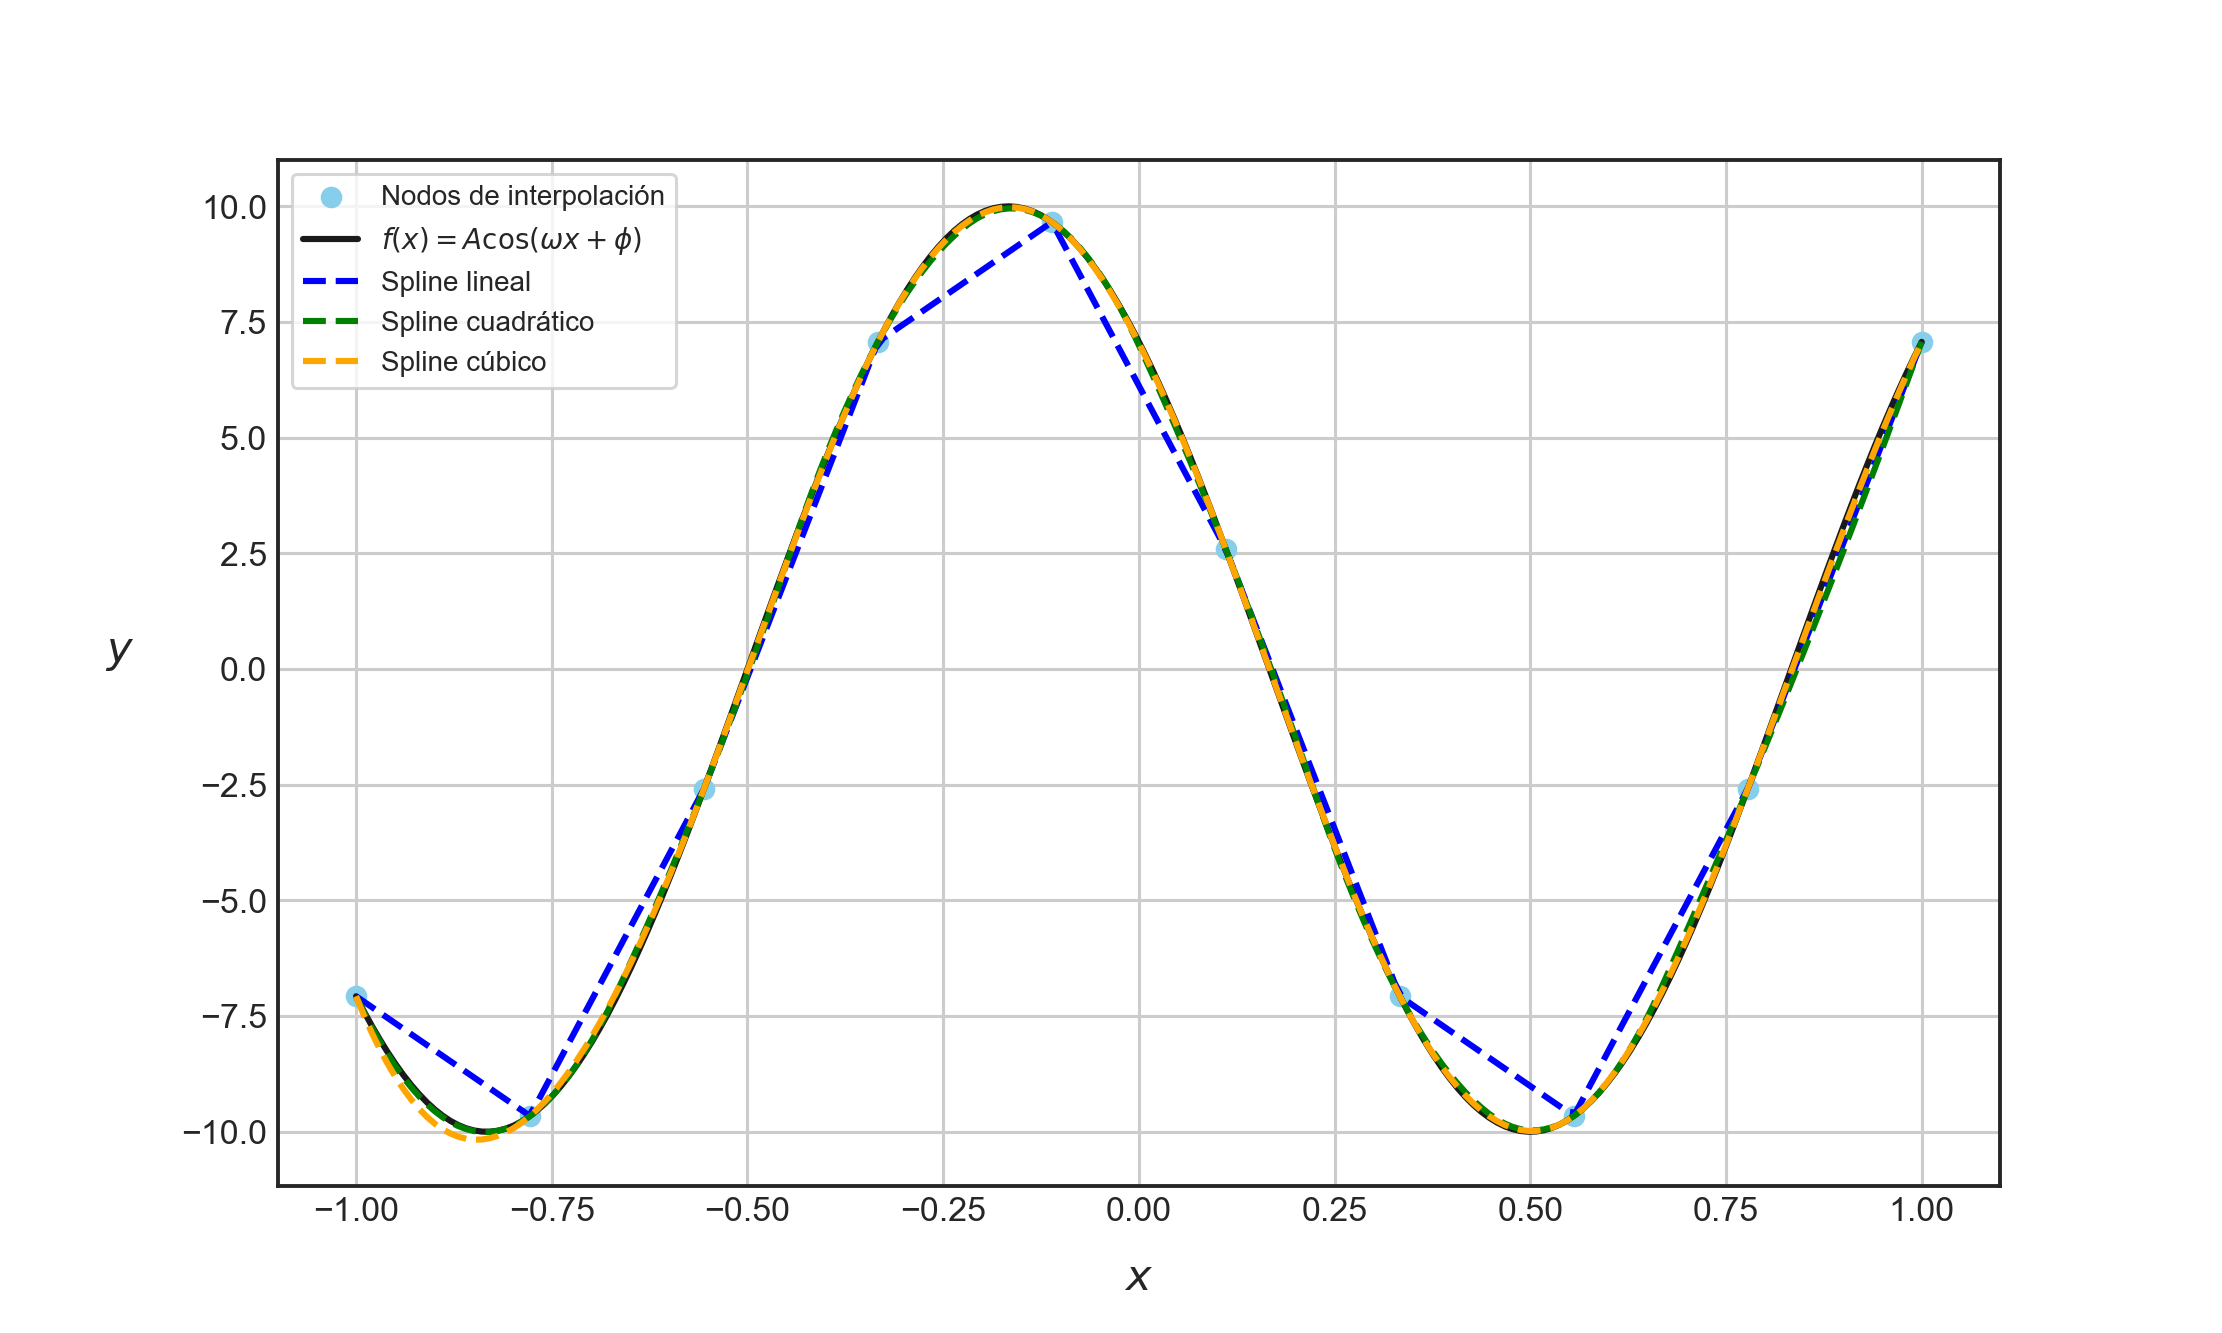

In [62]:
# Y graficamos los splines.
x_range = np.linspace(start=-1, stop=1, num=200)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x_nodes, sinusoidal(x_nodes), color="skyblue", label="Nodos de interpolación")
ax.plot(x_range, sinusoidal(x_range), color="k", lw=2, label=r"$f(x)=A\cos(\omega x+\phi)$")
ax.plot(x_range, s1(x_range), lw=2, linestyle="--", color="blue", label="Spline lineal")
ax.plot(x_range, s2(x_range), lw=2, linestyle="--", color="green", label="Spline cuadrático")
ax.plot(x_range, s3(x_range), lw=2, linestyle="--", color="orange", label="Spline cúbico")

ax.set_xlabel(r"$x$", fontsize=14, labelpad=10)
ax.set_ylabel(r"$y$", fontsize=14, labelpad=20, rotation=0)
ax.legend(fontsize=9, loc="upper left", frameon=True)
ax.grid(True);

Y ahí lo tenemos. Podemos observar que, para este ejemplo particular, bastaba con un spline cuadrático para lograr una aproximación de enorme calidad para nuestra función sinusoidal.